# Generate CCMP Figures

Generate figures for a paper on widening of the Tropics. The central analysis will be on 
latitudes of nulls in zonal mean zonal surface winds. It will also include nulls in the 
streamfunction in atmospheric analyses. 

First, imports and plot settings. 

In [1]:
import os
import re
import json
import numpy as np
from netCDF4 import Dataset, MFDataset
from datetime import datetime
import subprocess
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import cartopy.crs as ccrs
from tropicalwidth.libtropicalwidth import Model, averageWind, bucket, account

#  Plotting defaults. 

axeslinewidth = 0.5
plt.rcParams.update( {
  'font.family': "Helvetica", 
  'font.size': 9, 
  'font.weight': "normal", 
  'text.usetex': True, 
  'xtick.major.width': axeslinewidth, 
  'xtick.minor.width': axeslinewidth, 
  'ytick.major.width': axeslinewidth, 
  'ytick.minor.width': axeslinewidth, 
  'axes.linewidth': axeslinewidth } )


Define input parameters for plots. 

In [2]:
version = "v1"
dataroot = "../../Data"
outputroot = os.path.join( dataroot, "output" )

print( 'Syncing tropical width analyses from S3' )
ret = subprocess.run( [ 'aws', 's3', 'sync', f's3://{bucket}/output/', outputroot, '--profile', account ] )

seasons = [ { 'name': "All", 'monthrange': [1,12] }, 
            { 'name': "DJF", 'monthrange': [12,2] }, 
            { 'name': "MAM", 'monthrange': [3,5] }, 
            { 'name': "JJA", 'monthrange': [6,8] }, 
            { 'name': "SON", 'monthrange': [9,11] } 
          ]

Syncing tropical width analyses from S3


Open CCMP data files and perform linear regression by region, by season and all-months. 

In [3]:
inputfiles = sorted( [ os.path.join( outputroot, f ) for f in os.listdir( outputroot ) \
                      if re.search( r'^tropicalwidth\.\d{4}\.nc$', f ) ] )
print( 'inputfiles = \n  ' + "\n  ".join( inputfiles ) )

d = MFDataset( inputfiles, 'r' )
years = d.variables['years'][:]
months = d.variables['months'][:]
times = years + (months-0.5)/12

x = d.variables['methods'][:]
nmethods = x.shape[0]
methods = []
for i in range(nmethods): 
    m = np.logical_not( x[i,:].mask )
    methods.append( bytes( x[i,m] ).decode() )

x = d.variables['regions'][:]
nregions = x.shape[0]
regions = []
for i in range(nregions): 
    m = np.logical_not( x[i,:].mask )
    regions.append( bytes( x[i,m] ).decode() )
ccmp_regions = regions

ccmp_yearrange = [ years.min(), years.max() ]

print( 'methods = ' + ", ".join( methods ) )
print( 'regions = ' + ", ".join( regions ) )

ccmp_analyses = []

for imethod, method in enumerate( methods ): 
    for iregion, region in enumerate( regions ): 
        lats = d.variables['lats'][:,iregion,imethod]
    
        #  Compute annual cycle. 

        annualcycle = np.zeros( 12, dtype='f' )
        for imonth in range(12): 
            ii = ( months == imonth+1 )
            annualcycle[imonth] = lats[ii].mean()

        annualcycle -= annualcycle.mean()
    
        #  Compute departures from annual cycle. 

        dlats = lats - annualcycle[months-1]
     
        for season in seasons: 

            #  Select months by season. 
        
            ii0, ii1 = ( months >= season['monthrange'][0] ), ( months <= season['monthrange'][1] )
            if season['monthrange'][1] > season['monthrange'][0]: 
                ii = np.argwhere( np.logical_and( ii0, ii1 ) ).squeeze()
            else: 
                ii = np.argwhere( np.logical_or( ii0, ii1 ) ).squeeze()
            y = dlats[ii]
            x = times[ii]

            #  Linear regression. 
        
            timereference = x.mean()
            dx = ( x - timereference )
            trend = ( y * dx ).sum() / ( dx * dx ).sum()
            intercept = y.mean()

            #  Uncertainty analysis. 

            dy = y - trend*dx - intercept
            sigma2 = ( dy**2 ).sum() / ( x.size - 13 )
            phi = ( dy[:-1] * dy[1:] ).sum() / ( x.size - 14 ) / sigma2
            
            trenduncertainty = np.sqrt( sigma2 / ( dx * dx ).sum() * (1+phi)/(1-phi) )        

            #  Store results. 

            ccmp_analyses.append( { 
                'method': method, 
                'region': region, 
                'season': season['name'], 
                'lats': lats[ii],                 #  ...with annual cycle included...
                'times': x, 
                'annualcycle': annualcycle, 
                'timereference': timereference, 
                'trend': trend, 
                'intercept': intercept, 
                'sigma': np.sqrt( sigma2 ), 
                'trenduncertainty': trenduncertainty } )

d.close()

out = [ { 
            'method': a['method'], 
            'region': a['region'], 
            'season': a['season'], 
            'timereference': float( a['timereference'] ), 
            'trend': float( a['trend'] ), 
            'intercept': float( a['intercept'] ), 
            'sigma': float( a['sigma'] ), 
            'trenduncertainty': float( a['trenduncertainty'] ) } \
       for a in ccmp_analyses ]

savefile = 'ccmp_trends.json'
print( f'\nSaving data to {savefile}' )
with open( savefile, 'w' ) as f: 
    json.dump( out, f, indent='  ' )
    
#  Write in user-friendly table format. 

lines = [ '{:12s}  {:^80s}'.format( "Region", "Seasonal trends (uncertainty) [deg/decade]" ) ]
lines.append( " "*14 + "  ".join( [ f'{season["name"]:^14s}' for season in seasons ] ) )   

for hemisphere in [ "N", "S" ]: 
    for region in regions: 
        if region[0] != hemisphere: 
            continue
        line = f'{region:12s}'
        for season in seasons: 
            rec = [ rec for rec in ccmp_analyses if rec['region']==region and 
                   rec['season']==season['name'] and rec['method']=="All" ][0]
            line += f'  {rec["trend"]*10:6.3f} ({rec["trenduncertainty"]*10:5.3f})'
        lines.append( line )

#  To an ASCII output file. 

savefile = 'ccmp_trends.dat'
print( f'Saving CCMP trend data to {savefile}.' )
with open( savefile, 'w' ) as f: 
    f.write( "\n".join( lines ) + "\n" )

#  And to standard output. 

print( "\n" + "\n".join( lines ) )



inputfiles = 
  ../../Data/output/tropicalwidth.1995.nc
  ../../Data/output/tropicalwidth.1996.nc
  ../../Data/output/tropicalwidth.1997.nc
  ../../Data/output/tropicalwidth.1998.nc
  ../../Data/output/tropicalwidth.1999.nc
  ../../Data/output/tropicalwidth.2000.nc
  ../../Data/output/tropicalwidth.2001.nc
  ../../Data/output/tropicalwidth.2002.nc
  ../../Data/output/tropicalwidth.2003.nc
  ../../Data/output/tropicalwidth.2004.nc
  ../../Data/output/tropicalwidth.2005.nc
  ../../Data/output/tropicalwidth.2006.nc
  ../../Data/output/tropicalwidth.2007.nc
  ../../Data/output/tropicalwidth.2008.nc
  ../../Data/output/tropicalwidth.2009.nc
  ../../Data/output/tropicalwidth.2010.nc
  ../../Data/output/tropicalwidth.2011.nc
  ../../Data/output/tropicalwidth.2012.nc
  ../../Data/output/tropicalwidth.2013.nc
  ../../Data/output/tropicalwidth.2014.nc
  ../../Data/output/tropicalwidth.2015.nc
  ../../Data/output/tropicalwidth.2016.nc
  ../../Data/output/tropicalwidth.2017.nc
  ../../Data/output/

Get ERA5 data. 

In [4]:
inputfile = "era5_tropical_width.nc"

print( f'Reading {inputfile}' )
e = Dataset( inputfile, 'r' )

years = e.variables['years'][:]
months = e.variables['months'][:]
times = years + ( months - 0.5 )/12.0

regions = [ "NH", "SH" ]
nregions = len( regions )
era5_regions = regions

era5_analyses = []

for iregion, region in enumerate( regions ): 
    if region == "NH": 
        lats = e.variables['latNH'][:]
    elif region == "SH": 
        lats = e.variables['latSH'][:]
        
    #  Compute annual cycle. 

    annualcycle = np.zeros( 12, dtype='f' )
    for imonth in range(12): 
        ii = ( months == imonth+1 )
        annualcycle[imonth] = lats[ii].mean()

    annualcycle -= annualcycle.mean()
    
    #  Compute departures from annual cycle. 

    dlats = lats - annualcycle[months-1]
    
    for season in seasons: 

        #  Select months by season. 
        
        ii0, ii1 = ( months >= season['monthrange'][0] ), ( months <= season['monthrange'][1] )
        if season['monthrange'][1] > season['monthrange'][0]: 
            ii = np.argwhere( np.logical_and( ii0, ii1 ) ).squeeze()
        else: 
            ii = np.argwhere( np.logical_or( ii0, ii1 ) ).squeeze() 
        y = dlats[ii]
        x = np.ma.masked_where( y.mask, times[ii].data )

        #  Linear regression. 
        
        timereference = x.mean()
        dx = ( x - timereference )
        trend = ( y * dx ).sum() / ( dx * dx ).sum()
        intercept = y.mean()

        #  Uncertainty analysis. 

        dy = y - trend*dx - intercept
        sigma2 = ( dy**2 ).sum() / ( x.size - 13 )
        phi = ( dy[:-1] * dy[1:] ).sum() / ( x.size - 14 ) / sigma2
        trenduncertainty = np.sqrt( sigma2 / ( dx * dx ).sum() * (1+phi)/(1-phi) )        

        #  Store results. 

        era5_analyses.append( { 
            'region': region, 
            'season': season['name'], 
            'lats': lats[ii],              # ...including annual cycle...
            'annualcycle': annualcycle, 
            'times': x, 
            'timereference': timereference, 
            'trend': trend, 
            'intercept': intercept, 
            'trenduncertainty': trenduncertainty } )

e.close()

lines = [ '{:12s}  {:^80s}'.format( "Region", "Seasonal trends (uncertainty) [deg/decade]" ) ]
lines.append( " "*14 + "  ".join( [ f'{season["name"]:^14s}' for season in seasons ] ) )   

for hemisphere in [ "N", "S" ]: 
    for region in regions: 
        if region[0] != hemisphere: 
            continue
        line = f'{region:12s}'
        for season in seasons: 
            rec = [ rec for rec in era5_analyses if rec['region']==region and 
                   rec['season']==season['name'] ][0]
            line += f'  {rec["trend"]*10:6.3f} ({rec["trenduncertainty"]*10:5.3f})'
        lines.append( line )

print( "\n" + "\n".join( lines ) )

savefile = 'era5_trends.dat'
print( f'\nSaving CCMP trend data to {savefile}.' )
with open( savefile, 'w' ) as f: 
    f.write( "\n".join( lines ) + "\n" )

Reading era5_tropical_width.nc

Region                           Seasonal trends (uncertainty) [deg/decade]                   
                   All             DJF             MAM             JJA             SON      
NH             0.909 (0.253)   0.668 (0.273)   1.356 (0.590)   0.793 (0.470)   0.808 (0.346)
SH            -0.471 (0.090)  -0.431 (0.200)  -0.550 (0.160)  -0.258 (0.110)  -0.647 (0.219)

Saving CCMP trend data to era5_trends.dat.


## Process CMIP6 data for trends

In [5]:
datafile = "tropicalwidth_cmip6.nc"
print( f'Opening {datafile}' )

d = Dataset( datafile, 'r' )

#  Get regions. 

x = d.variables['regions'][:]
nregions = x.shape[0]
regions = []
for i in range(nregions): 
    m = np.logical_not( x[i,:].mask )
    regions.append( bytes( x[i,m] ).decode() )
cmip6_regions = regions

#  Define year range for linear regression. 

cmip6_yearrange = [ 1985, 2014 ]

#  Get unique models. 

allgroups = []

for groupname, group in d.groups.items(): 
    allgroups.append( { 
            'name': groupname, 
            'model': group.getncattr( "model" ), 
            'frequency': group.getncattr( "frequency" ), 
            'scenario': group.getncattr( "scenario" ), 
            'realization': group.getncattr( "realization" )
    } )

models = sorted( list( set( [ g['model'] for g in allgroups ] ) ) )
print( 'Unique models = ' + ", ".join( models ) )

#  Loop over models. 

cmip6_analyses = []

for model in models: 

    #  Select a single realization. 

    gname = sorted( [ g['name'] for g in allgroups if g['model']==model ] )[0]
    g = d.groups[gname]

    for iregion, region in enumerate( regions ): 
        years = g.variables['years'][:]
        ii = np.argwhere( np.logical_and( years >= cmip6_yearrange[0], years <= cmip6_yearrange[1] ) ).squeeze()
        years, months = g.variables['years'][ii], g.variables['months'][ii]
        times = years + ( months - 0.5 ) / 12
        lats = g.variables['lats'][ii,iregion]
    
        #  Compute annual cycle. 

        annualcycle = np.zeros( 12, dtype='f' )
        for imonth in range(12): 
            ii = ( months == imonth+1 )
            annualcycle[imonth] = lats[ii].mean()

        annualcycle -= annualcycle.mean()
    
        #  Compute departures from annual cycle. 

        dlats = lats - annualcycle[months-1]
     
        for season in seasons: 

            #  Select months by season. 
        
            ii0, ii1 = ( months >= season['monthrange'][0] ), ( months <= season['monthrange'][1] )
            if season['monthrange'][1] > season['monthrange'][0]: 
                ii = np.argwhere( np.logical_and( ii0, ii1 ) ).squeeze()
            else: 
                ii = np.argwhere( np.logical_or( ii0, ii1 ) ).squeeze()
            y = dlats[ii]
            x = times[ii]

            #  Linear regression. 
        
            timereference = x.mean()
            dx = ( x - timereference )
            trend = ( y * dx ).sum() / ( dx * dx ).sum()
            intercept = y.mean()

            #  Uncertainty analysis. 

            dy = y - trend*dx - intercept
            sigma2 = ( dy**2 ).sum() / ( x.size - 13 )
            phi = ( dy[:-1] * dy[1:] ).sum() / ( x.size - 14 ) / sigma2
            trenduncertainty = np.sqrt( sigma2 / ( dx * dx ).sum() * (1+phi)/(1-phi) )        

            #  Store results. 

            cmip6_analyses.append( { 
                'model': model, 
                'region': region, 
                'season': season['name'], 
                'lats': lats[ii],                 #  ...with annual cycle included...
                'times': x, 
                'annualcycle': annualcycle, 
                'timereference': timereference, 
                'trend': trend, 
                'intercept': intercept, 
                'sigma': np.sqrt( sigma2 ), 
                'trenduncertainty': trenduncertainty } )

d.close()

#  Saving computations to output JSON file. 

out = [ { 
            'model': a['model'], 
            'region': a['region'], 
            'season': a['season'], 
            'timereference': float( a['timereference'] ), 
            'trend': float( a['trend'] ), 
            'intercept': float( a['intercept'] ), 
            'sigma': float( a['sigma'] ), 
            'trenduncertainty': float( a['trenduncertainty'] ) } \
       for a in cmip6_analyses ]

savefile = 'cmip6_trends.json'
print( f'\nSaving data to {savefile}' )
with open( savefile, 'w' ) as f: 
    json.dump( out, f, indent='  ' )
    
#  Write in user-friendly table format. 

lines = []

for model in models: 
    lines.append( f'Model: {model}' )
    lines.append( '{:12s}  {:^80s}'.format( "Region", "Seasonal trends (uncertainty) [deg/decade]" ) )
    lines.append( " "*14 + "  ".join( [ f'{season["name"]:^14s}' for season in seasons ] ) )

    for hemisphere in [ "N", "S" ]: 
        for region in regions: 
            if region[0] != hemisphere: 
                continue
            line = f'{region:12s}'
            for season in seasons: 
                rec = [ rec for rec in cmip6_analyses if rec['region']==region and 
                       rec['season']==season['name'] and rec['model']==model ][0]
                line += f'  {rec["trend"]*10:6.3f} ({rec["trenduncertainty"]*10:5.3f})'
            lines.append( line )
    lines.append( "" )

#  To an ASCII output file. 

savefile = 'cmip6_trends.dat'
print( f'Saving CMIP6 model trend data to {savefile}.' )
with open( savefile, 'w' ) as f: 
    f.write( "\n".join( lines ) + "\n" )

#  And to standard output. 

print( "\n" + "\n".join( lines ) )


Opening tropicalwidth_cmip6.nc
Unique models = ACCESS-CM2, ACCESS-ESM1-5, BCC-CSM2-MR, CAMS-CSM1-0, CAS-ESM2-0, CMCC-CM2-HR4, CMCC-CM2-SR5, CNRM-CM6-1, CNRM-CM6-1-HR, CNRM-ESM2-1, CanESM5, EC-Earth3-AerChem, EC-Earth3-CC, EC-Earth3-Veg, EC-Earth3-Veg-LR, FGOALS-f3-L, GISS-E2-1-G, GISS-E2-2-G, HadGEM3-GC31-LL, HadGEM3-GC31-MM, IITM-ESM, INM-CM4-8, INM-CM5-0, IPSL-CM6A-LR, MIROC-ES2L, MIROC6, MPI-ESM-1-2-HAM, MPI-ESM1-2-HR, MPI-ESM1-2-LR, MRI-ESM2-0, UKESM1-0-LL

Saving data to cmip6_trends.json
Saving CMIP6 model trend data to cmip6_trends.dat.

Model: ACCESS-CM2
Region                           Seasonal trends (uncertainty) [deg/decade]                   
                   All             DJF             MAM             JJA             SON      
NH             0.273 (0.205)   0.305 (0.362)   0.640 (0.276)   0.422 (0.473)  -0.269 (0.395)
N Oceans       0.184 (0.223)   0.305 (0.429)   0.734 (0.298)  -0.068 (0.499)  -0.234 (0.416)
N Pacific      0.147 (0.310)   0.183 (0.408)   0.852 (0.3

## Figure: Timeseries of u=0 latitude

N Oceans bias =  0.27 degs, N Oceans rms = 0.514 degs
S Oceans bias = -0.05 degs, S Oceans rms = 0.269 degs
Generating figure2.N_Oceans-S_Oceans.v1.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


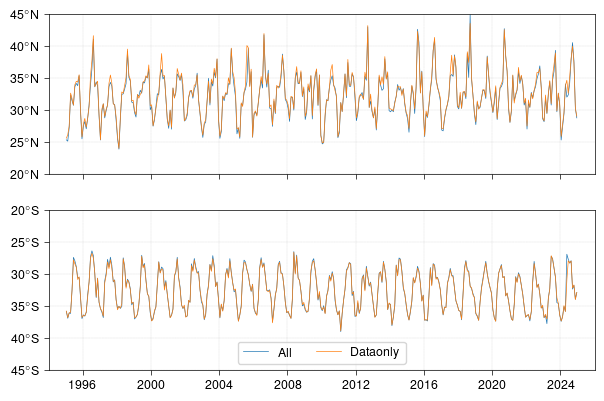

In [6]:
Nregion, Sregion = "N Oceans", "S Oceans"

fig = plt.figure( figsize=(6,4) )
regions = ccmp_regions

#  Northern Hemisphere. 

xticks = np.arange( ccmp_yearrange[0], ccmp_yearrange[1]+1.01, dtype='i' )
imajor = ( xticks/4.0 == np.int32( xticks/4.0 ) )

ax = fig.add_axes( [0.07,0.57,0.91,0.40] )
ax.set_xlim( ccmp_yearrange[0]-1, ccmp_yearrange[1]+2 )
ax.set_xticks( xticks[imajor] )
ax.set_xticklabels( [] )

ax.set_ylim( 20, 45 )
yticks = np.arange(20,46,5).astype('i')
ax.set_yticks( yticks )
ax.set_yticklabels( [ '{:2d}$^\circ$N'.format(ytick) for ytick in yticks ] )
ax.set_ylabel( '' )
ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )

region = Nregion
for imethod, method in enumerate(methods): 
    rec = [ rec for rec in ccmp_analyses if rec['region']==region and rec['method']==method and rec['season']=="All" ][0]
    ax.plot( rec['times'], rec['lats'], label=method, linewidth=0.5 )

#  Southern Hemisphere. 

ax = fig.add_axes( [0.07,0.08,0.91,0.40] )
ax.set_xlim( ccmp_yearrange[0]-1, ccmp_yearrange[1]+2 )
ax.set_xticks( xticks[imajor] )
ax.set_xticklabels( [ str(xtick) for xtick in xticks[imajor] ] )
# ax.set_xticks( xticks, minor=True )
# ax.set_xticklabels( [] )

ax.set_ylim( -45, -20 )
yticks = np.arange(-45,-19,5).astype('i')
ax.set_yticks( yticks )
ax.set_yticklabels( [ '{:2d}$^\circ$S'.format(np.abs(ytick)) for ytick in yticks ] )
ax.set_ylabel( '' )
ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )

region = Sregion
for imethod, method in enumerate(methods): 
    rec = [ rec for rec in ccmp_analyses if rec['region']==region and rec['method']==method and rec['season']=="All" ][0]
    ax.plot( rec['times'], rec['lats'], label=method, linewidth=0.5 )

ax.legend( ncol=2, loc='lower center' )

#  RMS difference, with and without data, for each hemisphere. 

rec0 = [ rec for rec in ccmp_analyses if rec['region']==Nregion and rec['method']=="Dataonly" ][0]
rec1 = [ rec for rec in ccmp_analyses if rec['region']==Nregion and rec['method']=="All" ][0]

diff = rec0['lats'] - rec1['lats']
bias = diff.mean()
rms = np.sqrt( ( (diff-bias)**2 ).sum() / (diff.size-1) )
print( f'{Nregion} bias = {bias:5.2f} degs, {Nregion} rms = {rms:5.3f} degs' )

rec0 = [ rec for rec in ccmp_analyses if rec['region']==Sregion and rec['method']=="Dataonly" and rec['season']=="All" ][0]
rec1 = [ rec for rec in ccmp_analyses if rec['region']==Sregion and rec['method']=="All" and rec['season'] == "All" ][0]

diff = rec0['lats'] - rec1['lats']
bias = diff.mean()
rms = np.sqrt( ( (diff-bias)**2 ).sum() / (diff.size-1) )
print( f'{Sregion} bias = {bias:5.2f} degs, {Sregion} rms = {rms:5.3f} degs' )

#  Close. 

epsfile = f'figure2.{Nregion}-{Sregion}.{version}.eps'.replace( " ", "_" )
print( "Generating " + epsfile )
fig.savefig( epsfile, format='eps' )


## Figure: Seasonal trend analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Generating figure3.v1.eps


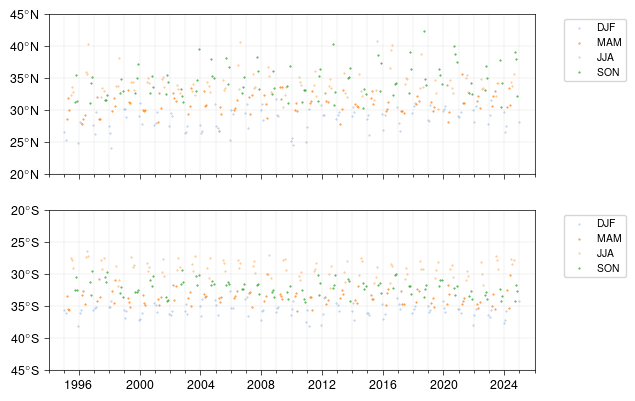

In [7]:
fig = plt.figure( figsize=(6,4) )

method = "All"
analyses = ccmp_analyses

xlim = [ ccmp_yearrange[0]-1, ccmp_yearrange[1]+2 ]
years = np.arange( ccmp_yearrange[0], ccmp_yearrange[1]+0.1, dtype=np.int32 )
xticks = np.arange( min( [ y for y in years if y % 4 == 0 ] ), years.max()+0.01, 4, dtype='i' )
xminor = years

cmap = plt.get_cmap( 'tab20' )

#  Loop over hemispheres. 

for ihemisphere, hemisphere in enumerate( [ "N", "S" ] ): 

    ax = fig.add_axes( [0.07,0.57-ihemisphere*0.49,0.81,0.40] )
    region = f'{hemisphere}H'

    ax.set_xlim( *xlim )
    ax.set_xticks( xticks )
    ax.set_xticklabels( [ str(xtick) for xtick in xticks ] )
    ax.xaxis.set_minor_locator( MultipleLocator(1) )

    if hemisphere == "N": 
        ax.set_ylim( 20, 45 )
        yticks = np.arange(20,46,5).astype('i')
        ax.set_xticklabels( [] )
    elif hemisphere == "S": 
        ax.set_ylim( -45, -20 )
        yticks = np.arange(-45,-19,5).astype('i')

    ax.set_yticks( yticks )
    ax.set_yticklabels( [ '{:2d}$^\circ${:}'.format(np.abs(ytick),hemisphere) for ytick in yticks ] )
    ax.set_ylabel( '' )
    ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )
        
    for iseason, season in enumerate(seasons):           
        if season['name'] == "All": 
            continue
        rec = [ rec for rec in analyses if rec['region']==region and rec['method']==method and rec['season']==season['name'] ][0]
        color = cmap( ( iseason + 0.5 ) / 20.0 )
        imonths = np.int32( rec['times'] * 12 ) - np.int32( rec['times'] ) * 12

        #  Calculate seasonal average. 

        ii = np.arange( 12, dtype='i' )
        ii1, ii2 = ( ii+1 >= season['monthrange'][0] ), ( ii+1 <= season['monthrange'][1] )
        if season['monthrange'][0] <= season['monthrange'][1]: 
            ii = np.argwhere( np.logical_and(ii1,ii2) ).squeeze()
        else: 
            ii = np.argwhere( np.logical_or(ii1,ii2) ).squeeze()

        seasonal_anomaly = rec['annualcycle'][ii].mean() - rec['annualcycle'].mean()
        clats = rec['lats'] - rec['annualcycle'][imonths] + seasonal_anomaly
        lw = 1.0
        ax.scatter( rec['times'], clats, label=f'{season["name"]}', color=color, s=0.2 )
            
    ax.legend( ncol=1, bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small" )

#  Close. 

epsfile = f'figure3.{version}.eps'
print( "Generating " + epsfile )
fig.savefig( epsfile, format='eps' )


## Figure: Plot of zonal mean zonal wind climatology

No OSCAR surface currents for 2024-03, s3path=oscar/2024/03/oscar_currents_202403.nc4
No OSCAR surface currents for 2024-04, s3path=oscar/2024/04/oscar_currents_202404.nc4
No OSCAR surface currents for 2024-05, s3path=oscar/2024/05/oscar_currents_202405.nc4
No OSCAR surface currents for 2024-06, s3path=oscar/2024/06/oscar_currents_202406.nc4
No OSCAR surface currents for 2024-07, s3path=oscar/2024/07/oscar_currents_202407.nc4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Generating figure4.v1.eps


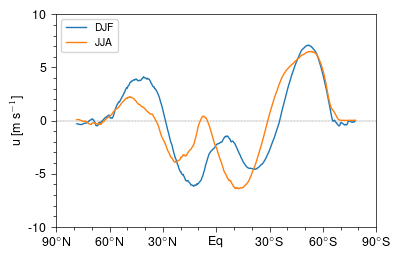

In [8]:
m = Model( model='monthly', dataroot=dataroot )
timerange = [ datetime.fromisoformat( f'{ccmp_yearrange[0]:4d}-01-01'), datetime.fromisoformat( f'{ccmp_yearrange[1]:4d}-12-31' ) ]
lats, ubar = averageWind( timerange, m )

#  Set up plot. 

fig = plt.figure( figsize=(4,2.5) )

ax = fig.add_axes( [0.15,0.12,0.80,0.85] )
ax.set_xlim( -90, 90 )
ax.set_xticks( np.arange( -90, 91, 30 ) )
ax.set_xticklabels( [ '90$^\circ$S', '60$^\circ$S', '30$^\circ$S', 'Eq', '30$^\circ$N', '60$^\circ$N', '90$^\circ$N' ] )
ax.xaxis.set_minor_locator( MultipleLocator(10) )
ax.invert_xaxis()
ax.set_xlabel( '' )

ax.set_ylim( -10, 10 )
yticks = np.arange( -10, 11, 5, dtype='i' )
ax.set_yticks( yticks )
ax.set_yticklabels( [ str(ytick) for ytick in yticks ] )
ax.yaxis.set_minor_locator( MultipleLocator(1) )
ax.set_ylabel( 'u [m s$^{-1}$]' )

ax.plot( [-90,90], [0,0], 'k--', lw=0.2 )
for season in [ 'DJF', 'JJA' ]: 
    u = np.ma.masked_where( ubar[season]==0.0, ubar[season] )
    ax.plot( lats, u, lw=1, label=season )

ax.legend( fontsize='small' )

epsfile = f'figure4.{version}.eps'
print( "Generating " + epsfile )
fig.savefig( epsfile, format='eps' )


## Figure: CCMP and ERA5 timeseries, full globe

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving to figure6.v1.eps


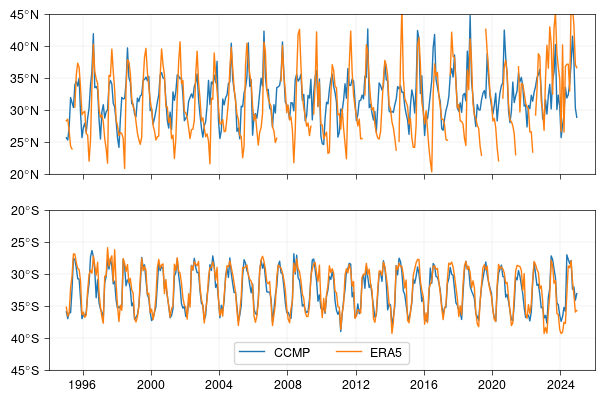

In [9]:
fig = plt.figure( figsize=(6,4) )

#  Northern Hemisphere. 

region = "NH"

xticks = np.arange( ccmp_yearrange[0], ccmp_yearrange[1]+1.01 )
imajor = ( xticks/4.0 == np.int32( xticks/4.0 ) )

ax = fig.add_axes( [0.07,0.57,0.91,0.40] )
ax.set_xlim( ccmp_yearrange[0]-1, ccmp_yearrange[1]+2 )
ax.set_xticks( xticks[imajor] )
ax.set_xticklabels( [] )

ax.set_ylim( 20, 45 )
yticks = np.arange(20,46,5).astype('i')
ax.set_yticks( yticks )
ax.set_yticklabels( [ '{:2d}$^\circ$N'.format(ytick) for ytick in yticks ] )
ax.set_ylabel( '' )
ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )

ccmp = [ rec for rec in ccmp_analyses if rec['region']==region and rec['method']=="All" and rec['season']=="All" ][0]
era5 = [ rec for rec in era5_analyses if rec['region']==region and rec['season']=="All" ][0]

ax.plot( ccmp['times'], ccmp['lats'], label="CCMP", linewidth=1.0 )
ax.plot( era5['times'], era5['lats'], label="ERA5", linewidth=1.0 )

#  Southern Hemisphere. 

region = "SH"

ax = fig.add_axes( [0.07,0.08,0.91,0.40] )
ax.set_xlim( ccmp_yearrange[0]-1, ccmp_yearrange[1]+2 )
ax.set_xticks( xticks[imajor] )
# ax.set_xticks( xticks, minor=True )
ax.set_xticklabels( [ str(int(xtick)) for xtick in xticks[imajor] ] )

ax.set_ylim( -45, -20 )
yticks = np.arange(-45,-19,5).astype('i')
ax.set_yticks( yticks )
ax.set_yticklabels( [ '{:2d}$^\circ$S'.format(np.abs(ytick)) for ytick in yticks ] )
ax.set_ylabel( '' )
ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )

ccmp = [ rec for rec in ccmp_analyses if rec['region']==region and rec['method']=="All" and rec['season']=="All" ][0]
era5 = [ rec for rec in era5_analyses if rec['region']==region and rec['season']=="All" ][0]

ax.plot( ccmp['times'], ccmp['lats'], label="CCMP", linewidth=1.0 )
ax.plot( era5['times'], era5['lats'], label="ERA5", linewidth=1.0 )

ax.legend( ncol=2, loc='lower center' )

epsfile = f'figure6.{version}.eps'
print( f'Saving to {epsfile}' )
fig.savefig( epsfile, format='eps' )

    

## Figure: Trend analysis with annual cycle removed

Saving to figure7.v1.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


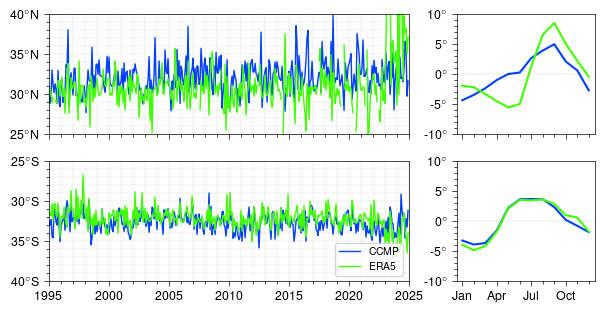

In [10]:
fig = plt.figure( figsize=(6,3) )
colors = { 'ccmp': "#0040FF", 'era5': "#40FF00" }
yearrange = [ 1995, 2024 ]
regionsuffix = "H"

for ihemisphere, hemisphere in enumerate( [ "N", "S" ] ): 

    regionname = f'{hemisphere}{regionsuffix}'
    ccmp_rec = [ rec for rec in ccmp_analyses if rec['region']==regionname and rec['method']=="All" ][0]
    if regionname in [ rec['region'] for rec in era5_analyses ]: 
        era5_rec = [ rec for rec in era5_analyses if rec['region']==regionname ][0]
    else: 
        era5_rec = None
    ax = fig.add_axes( [0.07,0.57-ihemisphere*0.49,0.60,0.40] )

    xticks = np.arange( yearrange[0], yearrange[1]+1.1, 5, dtype='i' )
    ax.set_xlim( yearrange[0], yearrange[1]+1 )
    ax.set_xticks( xticks )
    ax.xaxis.set_minor_locator( MultipleLocator(1) )
    ax.yaxis.set_minor_locator( MultipleLocator(1) )

    if hemisphere == "N": 
        ax.set_xticklabels( [] )
        ax.set_ylim( 25, 40 )
        yticks = np.arange(25,41,5).astype('i')
    else: 
        ax.set_xticklabels( [ str(xtick) for xtick in xticks ] )
        ax.set_ylim( -40, -25 )
        yticks = np.arange(-40,-24,5).astype('i')
        
    ax.set_yticks( yticks )
    ax.set_yticklabels( [ '{:2d}$^\circ${:}'.format(np.abs(ytick),hemisphere) for ytick in yticks ] )
    ax.set_ylabel( '' )
    ax.grid( which='both', axis='both', color='#808080', linestyle='--', lw=0.1 )

    for model, analysis in zip( ["ccmp","era5"], [ccmp_rec,era5_rec] ): 
        if analysis is None: continue
        times = analysis['times']
        imonths = np.int32( times * 12 ) - np.int32( times ) * 12
        clats = analysis['lats'] * 1.0
        for imonth in range(12): 
            ii = np.argwhere( imonths == imonth ).squeeze()
            clats[ii] -= analysis['annualcycle'][imonth]
        ax.plot( times, clats, lw=1.0, color=colors[model], label=model.upper() )

    if ihemisphere == 1: 
        ax.legend( loc="lower right", fontsize="small", ncols=1 )
        
    #  Annual cycle. 
    
    ax = fig.add_axes( [0.75,0.57-ihemisphere*0.49,0.23,0.40] )

    ax.set_xlim( -0.5, 11.5 )
    ax.set_xticks( np.arange(0,12,3,dtype='i') )
    ax.xaxis.set_minor_locator( MultipleLocator(1) )
    if ihemisphere == 0: 
        ax.set_xticklabels( [] )
    else: 
        ax.set_xticklabels( "Jan Apr Jul Oct".split() )

    yticks = np.arange(-10,10.1,5).astype('i')
    ax.set_ylim( -10, 10 )
    ax.set_yticks( yticks )
    ax.set_yticklabels( [ '{:3d}$^\circ$'.format(ytick) for ytick in yticks ] )
    ax.yaxis.set_minor_locator( MultipleLocator(1) )
    ax.set_ylabel( '' )

    ax.plot( [-1,13], [0,0], ls="--", lw=0.1, color="#404040" )

    for model, analysis in zip( ["ccmp","era5"], [ccmp_rec,era5_rec] ): 
        if analysis is None: continue
        cycle = analysis['annualcycle']
        ax.plot( cycle-cycle.mean(), color=colors[model], label=model.upper() )

if regionsuffix=="H": 
    epsfile = f'figure7.{version}.eps'
else: 
    epsfile = f'figure7.{regionsuffix.strip()}.{version}.eps'
    
print( f'Saving to {epsfile}' )
fig.savefig( epsfile, format='eps' )


##  Graphical table of trends

Saving to figure8.v1.eps


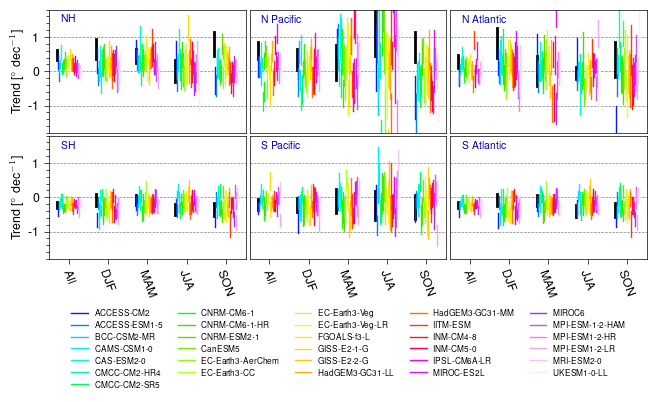

In [11]:
fig = plt.figure( figsize=(6.5,4.0) )

suffixes = [ "H", "Pacific", "Atlantic" ]
hemispheres = [ "N", "S" ]
method = "All" 

xlim = [ -0.5, len(seasons)-0.5 ]
xticks = np.arange( len(seasons), dtype='i' )

ylim = [ -1.8, 1.8 ]
yticks = np.arange( -1.0, 1.001, 1, dtype='f' )
yminor = 0.2

superframe = np.array( [ 0.065, 0.35, 0.925, 0.63 ] )
subframe = np.array( [ 0.01, 0.01, 0.98, 0.98 ] )

models = sorted( list( set( [ rec['model'] for rec in cmip6_analyses ] ) ) )
nmodels = len( models )
dx = 0.6
cmap = plt.get_cmap( 'gist_ncar' )
colors = [ cmap( 0.1 + 0.9*(imodel+0.5)/nmodels ) for imodel in range(nmodels) ]

nx, ny = len(suffixes), len(hemispheres)

for ihemisphere, hemisphere in enumerate( hemispheres ): 
    for isuffix, suffix in enumerate( suffixes ): 
            
        pos = ( subframe + np.array( [ isuffix, ny-ihemisphere-1, 0, 0 ] ) ) / np.array( [ nx, ny, nx, ny ] )
        pos = np.array([superframe[0],superframe[1],0,0]) + np.array([superframe[2],superframe[3],superframe[2],superframe[3]]) * pos
        ax = fig.add_axes( pos )

        ax.set_xlim( *xlim )
        ax.set_ylim( *ylim )

        for ytick in yticks: 
            ax.plot( xlim, [ytick,ytick], color="#808080", lw=0.5, ls='--' )
        
        #  Define region. 

        if suffix == "H": 
            region = f'{hemisphere}{suffix}'
        else: 
            region = f'{hemisphere} {suffix}'

        ax.text( -0.2, ylim[0]+(ylim[1]-ylim[0])*0.9, region, fontsize="small", color="#0000C0" )
        
        if isuffix == 0: 
            ax.set_yticks( yticks )
            ax.set_yticklabels( [ str(int(ytick)) for ytick in yticks ] )
            ax.yaxis.set_minor_locator( MultipleLocator(yminor) )
            ax.set_ylabel( 'Trend [$^\circ$ dec$^{-1}$]' )
        else: 
            ax.set_yticks( [] )

        if ihemisphere == 0: 
            ax.set_xticks( [] )
        else: 
            ax.set_xticks( xticks )
            ax.set_xticklabels( [ season['name'] for season in seasons ], rotation=-70 )

        #  Plot bar for each season in CCMP analyses. 

        for iseason, season in enumerate(seasons): 
            rec = [ rec for rec in ccmp_analyses if rec['method']==method and rec['season']==season['name'] and rec['region']==region ][0]
            x = iseason * np.array([1,1]) - 0.5 * dx
            y = rec['trend'] + rec['trenduncertainty'] * np.array([-1,1])
            ax.plot( x, y*10, lw=2, color='k' )

        #  Plot bar for each season in CMIP6 analyses. 

        for imodel, model in enumerate( models ): 
            for iseason, season in enumerate(seasons): 
                rec = [ rec for rec in cmip6_analyses if rec['model']==model and rec['season']==season['name'] and rec['region']==region ][0]
                x = iseason * np.array([1,1]) + ( (imodel+1)/nmodels - 0.5 ) * dx
                y = rec['trend'] + rec['trenduncertainty'] * np.array([-1,1])
                if iseason==0: 
                    ax.plot( x, y*10, lw=1, color=colors[imodel], label=model )                    
                else: 
                    ax.plot( x, y*10, lw=1, color=colors[imodel] )
        if ihemisphere==1 and isuffix==1: 
            ax.legend( ncol=5, bbox_to_anchor=(0.5,-0.35), loc="upper center", fontsize=6, frameon=False )
            
epsfile = f'figure8.{version}.eps'
print( f'Saving to {epsfile}' )
fig.savefig( epsfile, format='eps' )


## Plots of CCMP density

Saving to ccmpcounts.eps


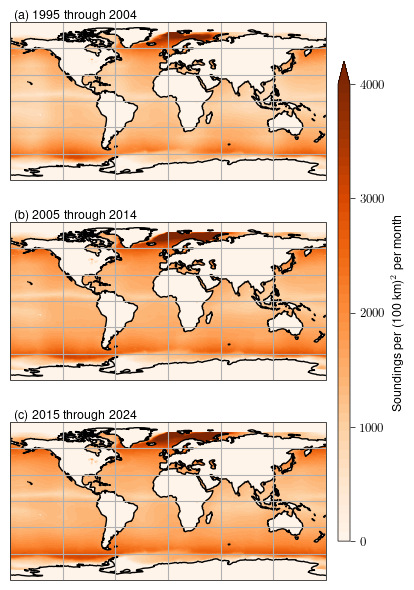

In [12]:
epsfile = "ccmpcounts.eps"

countsfile = "ccmpcounts.nc"
if not os.path.exists( countsfile ): 
    print( f'Downloading {counstilfe}' )
    ret = subprocess.run( [ 'aws', 's3', 'cp', f's3://aer-sleroy-tropical-width/ccmp/{countsfile}', f'./{countsfile}', '--profile', 'aerdev' ] )

d = Dataset( countsfile, 'r' )
lons = d.variables['longitude'][:]
lats = d.variables['latitude'][:]

#  Compute area elements. 

Re = 6378.135      # km
dlon = 2 * np.pi / lons.size

sinmidlats = np.zeros( lats.size+1 )
sinmidlats[1:-1] = np.sin( np.deg2rad( 0.5 * ( lats[1:] + lats[:-1] ) ) )
if lats[0] < lats[1]: 
    sinmidlats[0], sinmidlats[-1] = -1.0, 1.0
else: 
    sinmidlats[0], sinmidlats[-1] = 1.0, -1.0
dsinmidlats = np.abs( sinmidlats[1:] - sinmidlats[:-1] )
da = dsinmidlats * dlon * Re**2

#  Contour plots. 

fig = plt.figure( figsize=(4,6) )
levels = np.arange( 0.0, 1.01, 0.02 ) * 4000
cmap = plt.get_cmap( 'Oranges' )
years = d.variables['year'][:]

for i in range(3): 
    
    yearrange = 1995 + 10*i + np.array( [0,9] )
    ii = np.argwhere( np.logical_and( years >= yearrange[0], years <= yearrange[1] ) ).squeeze()
    m = d.variables['nobs'][ii,:,:].mean(axis=0)
    m = ( m.T * ( 100.0 )**2 / da ).T

    ax = fig.add_axes( [0.01,(0.05+2-i)/3,0.79,0.90/3], projection=ccrs.PlateCarree() )
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.text( -175, 94, "({:}) {:4d} through {:4d}".format( chr( ord('a')+i ), yearrange[0], yearrange[1] ) )
    last_ax = ax.contourf( lons, lats, m, levels=levels, cmap=cmap, extend="max" )

    if i == 1: 
        cax = fig.add_axes( [0.83,0.1,0.03,0.8] )
        fig.colorbar( last_ax, cax=cax, orientation="vertical", extend="max", 
                     ticks=np.arange(0,4000.1,1000), label="Soundings per (100 km)$^2$ per month" )
        
print( f'Saving to {epsfile}' )
fig.savefig( epsfile )

d.close()


## Sounding density timeseries

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Creating ccmp_midlat_density_timeseries.eps


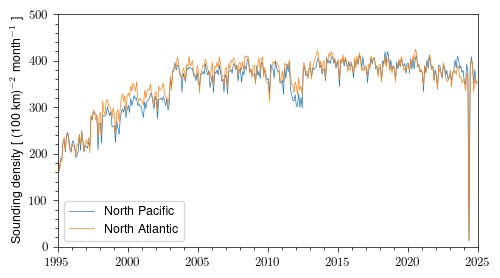

In [13]:
epsfile = "ccmp_midlat_density_timeseries.eps"

countsfile = "ccmpcounts.nc"
if not os.path.exists( countsfile ): 
    print( f'Downloading {counstilfe}' )
    ret = subprocess.run( [ 'aws', 's3', 'cp', f's3://aer-sleroy-tropical-width/ccmp/{countsfile}', f'./{countsfile}', '--profile', 'aerdev' ] )

d = Dataset( countsfile, 'r' )
lons = d.variables['longitude'][:]
lats = d.variables['latitude'][:]
years = d.variables['year'][:]
months = d.variables['month'][:]

#  Justify longitudes. 

ii = ( lons >= 180 )
lons[ii] -= 360

#  Compute area elements. 

Re = 6378.135      # km
dlon = 2 * np.pi / lons.size

sinmidlats = np.zeros( lats.size+1 )
sinmidlats[1:-1] = np.sin( np.deg2rad( 0.5 * ( lats[1:] + lats[:-1] ) ) )
if lats[0] < lats[1]: 
    sinmidlats[0], sinmidlats[-1] = -1.0, 1.0
else: 
    sinmidlats[0], sinmidlats[-1] = 1.0, -1.0
dsinmidlats = np.abs( sinmidlats[1:] - sinmidlats[:-1] )
da = dsinmidlats * dlon * Re**2

#  Select North Pacific zone. 

regions = [ 
    { 'name': "North Pacific", 'latrange': [ 25, 40 ], 'lonrange': [ 165, -135 ] }, 
    { 'name': "North Atlantic", 'latrange': [ 25, 40 ], 'lonrange': [ -75, -15 ] } ]    

ilats = np.argwhere( np.logical_and( lats >= 25, lats <= 40 ) ).squeeze()

for region in regions: 
    if region['lonrange'][0] < region['lonrange'][1]: 
        ilons = np.argwhere( np.logical_and( region['lonrange'][0] <= lons, lons <= region['lonrange'][1] ) ).squeeze()
    else: 
        ilons = np.argwhere( np.logical_or( region['lonrange'][0] <= lons, lons <= region['lonrange'][1] ) ).squeeze()
    m = d.variables['nobs'][:,ilats,ilons].mean(axis=2) @ ( 100.0**2/(ilons.size*da[ilats]) )
    region.update( { 'density': m } )
    
d.close()

#  Compose plot. 

fig = plt.figure( figsize=(5,2.5) )
ax = fig.add_axes( [0.14,0.15,0.84,0.93] )
ax.set_xlim( 1995, 2025 )
ax.set_xticks( np.arange(1995,2025.01,5) )
ax.set_xticks( np.arange(1995,2025.01,1), minor=True )
ax.set_ylim( 0, 500 )
ax.set_yticks( np.arange(0,500.1,100) )
ax.set_yticks( np.arange(0,500.1,20), minor=True )
ax.set_ylabel( "Sounding density [ (100 km)$^{-2}$ month$^{-1}$ ]" )

for region in regions: 
    ax.plot( years + (months-0.5)/12, region['density'], lw=0.5, label=region['name'] )

ax.legend()

print( f'Creating {epsfile}' )
plt.savefig( epsfile )
